# Outlier Analysis - Initial Looks Part 1

Behind the clusters that I found [here](http://www.nkallfa.com/shiny/Similar-Government-Contractors-App/app/) I used singular value decomposition (SVD) to reduce my data to 5 dimensions. You can get an idea of the shape of your data by plotting the singular vectors against one another. Let's take a look at the plot of the top two singular vectors against one another and then let's plot all 5 against each other. 

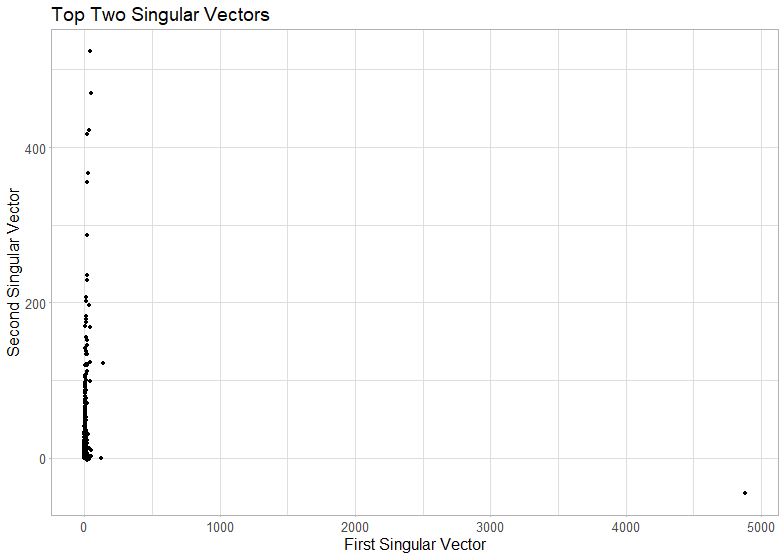

In [1]:
from IPython.display import Image
Image(filename="..\\..\\figs\\top_2_singular_vectors_unique_piids.png")

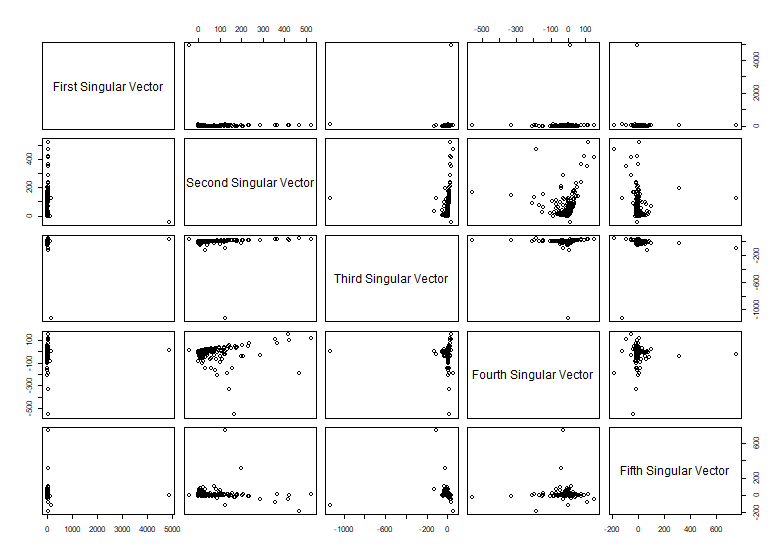

In [2]:
from IPython.display import Image
Image(filename="..\\..\\figs\\all_5_singular_vectors_unique_piids.png")

Notice that almost all of the points are concentrated in a tiny corner of the plots. This is not what we want to see when we reduce dimensions. We want to reduce the dimensionality of the data and then cluster on the reduced space. If I were to cluster on this data I'd probably get a few small-sized clusters and then one really large cluster that contains most of the companies. It's basically completely meaningless, so let's try to explain why I think I am getting what I am getting. 

Let's recall the underlying data I use prior to clustering. The data represents counts of the number of "contracts" a company has under each NAICS code. While this sounds simple enough it's slightly more complicated than that because of how I am counting contracts. FPDS data contain a procurement instrument identifier (PIID) which is a unique ID assigned to each solicitation, contract, agreement, or order a company makes with the government. I try to get an accurate count of the number of contracts a company has by counting the number of unique PIIDs under each NAICS code. Since a PIID can be used for other things besides contract counting unique PIIDs is not a good representation. This leads to very skewed data. First of all, it's very sparse (mostly zeros) and most companies have just a handful of unique PIIDs. Meanwhile, because a PIID is used for more than just contracts there are some companies that have tens of thousands of unique PIIDs. 

In this notebook I thought I could start exploring the data (prior to clustering) to give a sense of the types of problems I am dealing with. In particular, I want to explore the outliers in my data set: those companies with lots of unique PIIDs. Let's take a look at some of these outliers as well as the distribution of the data.

### Import packages

In [3]:
import pandas as pd
import seaborn as sns
%matplotlib inline

### Load and Preview Data

In [4]:
df_original = pd.read_csv(filepath_or_buffer = "..\\..\\data\\1_raw_data_from_database.csv", 
                          sep = "\t")

In [5]:
display(df_original.head(5))

,dollarsobligated,contractactiontype,typeofcontractpricing,vendorname,dunsnumber,parentdunsnumber,psc_cat,productorservicecode,principalnaicscode,piid,modnumber
0,112000.0,DO Delivery Order,J: FIRM FIXED PRICE,E H A R C INC,194058574.0,194058574.0,G,G004: SOCIAL- SOCIAL REHABILITATION,623990: OTHER RESIDENTIAL CARE FACILITIES,VA26116J5000,0
1,45000.0,PO Purchase Order,J: FIRM FIXED PRICE,"PEREGRINE INTEGRATED MANAGEMENT, INC",964585058.0,964585058.0,U,U099: EDUCATION/TRAINING- OTHER,611430: PROFESSIONAL AND MANAGEMENT DEVELOPMEN...,VA26315P1022,0
2,2680.0,DCA Definitive Contract,J: FIRM FIXED PRICE,"ADVANCED TECHNOLOGY SOLUTIONS, INC.",178077905.0,178077905.0,R,R702: SUPPORT- MANAGEMENT: DATA COLLECTION,561440: COLLECTION AGENCIES,VA263P1401,P00005
3,5000.0,DCA Definitive Contract,J: FIRM FIXED PRICE,HAAS GROUP INTERNATIONAL INC.,2275782.0,809073245.0,F,F999: OTHER ENVIRONMENTAL SERVICES,541620: ENVIRONMENTAL CONSULTING SERVICES,VA528P0961,P00007
4,0.0,DO Delivery Order,J: FIRM FIXED PRICE,RADIOMETER AMERICA INC.,86661485.0,24744476.0,66,6630: CHEMICAL ANALYSIS INSTRUMENTS,334516: ANALYTICAL LABORATORY INSTRUMENT MANUF...,VA549C20155,P00007


The data seen above comes directly from FPDS after removing all unnecessary columns. Some of the important fields I have been using are parentdunsnumber, principalnaicscode, dollarsobligated, and piid.

Before we start looking at some of the outliers we need to get one vendor name for each DUNS number. This isn't necessary, but I'd rather read a vendor name instead of a DUNS number. One simple way of doing that is grouping by the DUNS number and vendor name and count the number of times each vendor name appears in the data taking the most frequent vendor name. The next block of code does that for us. 

### Get 1 vendorname for each parent DUNS number

In [6]:
vendornames = pd.DataFrame(df_original.groupby(["parentdunsnumber", "vendorname"]).vendorname.agg(["count"]).reset_index())
vendornames.sort_values(by = ["parentdunsnumber","count"],
                        ascending = False,
                        inplace = True)
vendornames = vendornames.groupby("parentdunsnumber").head(1).reset_index(drop = True).drop(labels = "count", 
                                                                                            axis = 1)
vendornames.head(5)

,parentdunsnumber,vendorname
0,989977066.0,"JAZZ PHARMACEUTICALS, INC."
1,989145297.0,REALTIME TECHNOLOGIES LIMITED
2,988981601.0,STATISTICAL SOLUTIONS LTD
3,988946034.0,G4S GLOBAL RISKS LIMITED
4,988819256.0,"BACON-UNIVERSAL COMPANY, INC."


### Count Number of Unique PIIDs, Sort, and Return Top 10
Now that we have one vendor name for each unique DUNS number, we can start looking at some of the outliers in the data. Let's count the number of unique PIIDs for each DUNS number and return the top 10.

In [7]:
n_contracts = pd.DataFrame(df_original.groupby(["parentdunsnumber"]).piid.nunique().reset_index())
total_obligated = pd.DataFrame(df_original.groupby(["parentdunsnumber"]).dollarsobligated.sum().reset_index())
n_contracts.parentdunsnumber.apply(str)
total_obligated.parentdunsnumber.apply(str)
n_contract_total_obligated = n_contracts.merge(right = total_obligated,
                                               on = "parentdunsnumber",
                                               how = "left")
n_contract_total_obligated.sort_values(by = "piid",
                                       ascending = False,
                                       inplace = True)


# Data Distribution

Let's try to get a first glimpse of what our data looks like. I've taken the first 5 columns of our data (NAICS coes 111110, 111120, 111130, 111140, 111150) and stacked the columns on top of one another keeping track of what NAICS code it belongs to. I show the first five rows of this table below. If we went down far enough in this table we would eventually see the other NAICS codes. 

Using this table I group by each unique NAICS-value combination counting the number of times they appear. You can see this in the second block of code below.

In [58]:
first_5_naics = pd.read_csv(filepath_or_buffer = "..\\..\\data\\first_5_naics_melted.csv", 
                          sep = ",")
first_5_naics.columns = ["NAICS", "Value"]
first_5_naics.head()

,NAICS,Value
0,111110,0
1,111110,0
2,111110,0
3,111110,0
4,111110,0


In [59]:
count_values = first_5_naics.groupby(["NAICS", "Value"]).size()
naics_value_counts = count_values.to_frame(name = "Occurences").reset_index()
naics_value_counts.columns = ["NAICS", "Value", "Occurences"]
naics_value_counts

,NAICS,Value,Occurences
0,111110,0,132147
1,111110,1,24
2,111110,2,4
3,111110,3,1
4,111110,7,1
5,111120,0,132171
6,111120,1,5
7,111120,6,1
8,111130,0,132168
9,111130,1,9


The data is very sparse so that's something we are going to have to deal with if we want to get meaningful clusters. If we take a closer look at the distribution of the number of unique PIIDs we see an extremely skewed distribution. **75% of the companies have only 1-5 unique PIIDs, whereas the maximum has 101,410!** It's issues like this with the underlying shape of the data that I believe is causing issues with the dimensionality reduction and, ultimately, with the clustering as well. 

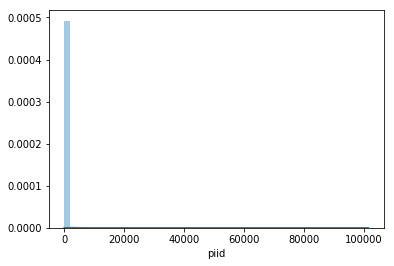

In [81]:
sns.distplot(a = n_contract_total_obligated.piid)

In [82]:
n_contract_total_obligated.piid.describe()

count    132729.000000
mean         24.317308
std         583.922276
min           1.000000
25%           1.000000
50%           2.000000
75%           5.000000
max      101410.000000
Name: piid, dtype: float64

# Top 10 PIID Counts

Now that we know a bit about the distribution let's look at the companies that have the most unique PIID counts and see if we can begin to understand why. 

In [83]:
top_10_piid = n_contract_total_obligated.head(10)
top_10_piid.merge(right = vendornames,
                  on = "parentdunsnumber",
                  how = "left")

,parentdunsnumber,piid,dollarsobligated,vendorname
0,834951691.0,101410,4.332757e+10,LOCKHEED MARTIN CORPORATION
1,97537435.0,72163,8.911149e+08,"CARDINAL HEALTH 200, LLC"
2,847412269.0,66608,2.214639e+08,"OWENS & MINOR DISTRIBUTION, INC."
3,177667227.0,55561,8.635390e+09,MCKESSON CORPORATION
4,78745061.0,48497,3.254708e+09,SCIENCE APPLICATIONS INTERNATIONAL CORPORATION
5,12430880.0,48218,3.558737e+07,"HENRY SCHEIN, INC."
6,123456787.0,43256,1.210826e+09,MISCELLANEOUS FOREIGN AWARDEES
7,116057019.0,40889,2.707047e+08,SUPPLYCORE INC.
8,5070479.0,40695,2.222620e+08,CATERPILLAR INC.
9,75553560.0,38985,1.760567e+07,"EASTERN CAROLINA VOCATIONAL CENTER, INC."


Some companies on this list are familiar to me (Lockheed Martin, SAIC , McKeeson Corporation, Caterpillar) and others I have never heard of (Cardinal Health, Owens & Minor, Henry Schein, Eastern Carolina Vocational Center, Supplycore). However, there seems to be some common threads: Cardinal Health, Owens & Minor, McKeeson Corporation, and Henry Schein are all involved in the health care industry. Eastern Carolina Vocational Center is an employment services organization for people with disabilities in Eastern North Carolina and SupplyCore seems to be involved in logistics from what I read online. Let's just take a closer look at the top 5 and see what NAICS codes are most common.

## Lockheed Martin

Almost all of the PIIDs for Lockheed Martin are in 332710: Machine Shops which comprises establishments primarily engaged in machining metal and plastic parts and parts of other composite materials on a job or order basis. [Lockheed Martin](https://en.wikipedia.org/wiki/Lockheed_Martin) is an aerospace, defense, security and technologies company. This doesn't appear to give the best representation of what Lockheed Martin does.

In [84]:
Lockheed = df_original.loc[df_original.parentdunsnumber == 834951691,].groupby(["principalnaicscode"]).piid.nunique().reset_index()
Lockheed.sort_values(by = "piid",
                     ascending = False,
                     inplace = True)
Lockheed.head(10)

,principalnaicscode,piid
22,332710: MACHINE SHOPS,96007
80,336411: AIRCRAFT MANUFACTURING,5236
82,336413: OTHER AIRCRAFT PARTS AND AUXILIARY EQU...,4492
23,"332722: BOLT, NUT, SCREW, RIVET, AND WASHER MA...",1369
116,541330: ENGINEERING SERVICES,1094
140,561990: ALL OTHER SUPPORT SERVICES,582
53,334412: BARE PRINTED CIRCUIT BOARD MANUFACTURING,361
59,"334511: SEARCH, DETECTION, NAVIGATION, GUIDANC...",276
119,541512: COMPUTER SYSTEMS DESIGN SERVICES,269
129,541712: RESEARCH AND DEVELOPMENT IN THE PHYSIC...,223


## Cardinal Health 200

Most of the PIIDs for Cardinal Health fall under 423450: Medical, Dental, and Hospital Equipment and Supplies Merchant Wholesalers. This code is for companies engaged in the merchant wholesale distribution of professional medical equipment, instruments, and supplies. It's definitely relevant for a company that [specializes in distribution of pharmaceuticals and medical products](https://en.wikipedia.org/wiki/Cardinal_Health), but maybe it gives too much weight to one NAICS code.  

In [85]:
Cardinal_Health = df_original.loc[df_original.parentdunsnumber == 97537435,].groupby(["principalnaicscode"]).piid.nunique().reset_index()
Cardinal_Health.sort_values(by = "piid",
                            ascending = False,
                            inplace = True)
Cardinal_Health.head(10)

,principalnaicscode,piid
13,"423450: MEDICAL, DENTAL, AND HOSPITAL EQUIPMEN...",65805
1,325412: PHARMACEUTICAL PREPARATION MANUFACTURING,5676
0,325411: MEDICINAL AND BOTANICAL MANUFACTURING,2037
10,339112: SURGICAL AND MEDICAL INSTRUMENT MANUFA...,434
11,339113: SURGICAL APPLIANCE AND SUPPLIES MANUFA...,139
14,424210: DRUGS AND DRUGGISTS' SUNDRIES MERCHANT...,19
7,334516: ANALYTICAL LABORATORY INSTRUMENT MANUF...,17
30,811219: OTHER ELECTRONIC AND PRECISION EQUIPME...,7
2,325413: IN-VITRO DIAGNOSTIC SUBSTANCE MANUFACT...,6
12,339999: ALL OTHER MISCELLANEOUS MANUFACTURING,5


## Owens and Minor

Owens & Minor is similar to Cardinal Health in that most of its PIIDs fall under 423450 again, but there is only one other NAICS code they use. This actually seems to get at what Owens and Minor do from skimming their Wikipedia page [here](https://en.wikipedia.org/wiki/Owens_%26_Minor).

In [86]:
Owen_Minor = df_original.loc[df_original.parentdunsnumber == 847412269,].groupby(["principalnaicscode"]).piid.nunique().reset_index()
Owen_Minor.sort_values(by = "piid",
                            ascending = False,
                            inplace = True)
Owen_Minor.head(10)

,principalnaicscode,piid
1,"423450: MEDICAL, DENTAL, AND HOSPITAL EQUIPMEN...",66575
0,339113: SURGICAL APPLIANCE AND SUPPLIES MANUFA...,33


## McKeeson Corporation

Most of their NAICS codes are under 325411: Medicinal and Botanical Manufacturing. This code consists of companies engaged in the following:

1. Manufacturing uncompounded medicinal chemicals and their derivatives (i.e., generally for use by pharmaceutical preparation manufacturers) and/or
2. Grading, grinding, and milling uncompounded botanicals.

According to [Wikipedia](https://en.wikipedia.org/wiki/McKesson_Corporation) the company distributes pharmaceuticals and provides health information technology, medical supplies, and care management tools. This seems to get at what they do, but should it really represent 85% of their unique PIIDs? I'm not sure.

In [87]:
Mckeeson_Corp = df_original.loc[df_original.parentdunsnumber == 177667227,].groupby(["principalnaicscode"]).piid.nunique().reset_index()
Mckeeson_Corp.sort_values(by = "piid",
                            ascending = False,
                            inplace = True)
Mckeeson_Corp.head(10)

,principalnaicscode,piid
1,325411: MEDICINAL AND BOTANICAL MANUFACTURING,47387
2,325412: PHARMACEUTICAL PREPARATION MANUFACTURING,7071
15,424210: DRUGS AND DRUGGISTS' SUNDRIES MERCHANT...,662
16,446110: PHARMACIES AND DRUG STORES,208
14,"423450: MEDICAL, DENTAL, AND HOSPITAL EQUIPMEN...",114
31,622110: GENERAL MEDICAL AND SURGICAL HOSPITALS,23
11,339113: SURGICAL APPLIANCE AND SUPPLIES MANUFA...,23
10,339112: SURGICAL AND MEDICAL INSTRUMENT MANUFA...,15
19,511210: SOFTWARE PUBLISHERS,12
4,325414: BIOLOGICAL PRODUCT (EXCEPT DIAGNOSTIC)...,8


## SAIC

Finally we have SAIC which I was surprised to learn had a lot of PIIDs under 326211: Tire Manufacturing. This code is for companies engaged in manufacturing tires and inner tubes from natural and synthetic rubber. I have heard of SAIC before and have seen job postings they have for data scientists, software engineers, etc... I was surprised to learn they also make tires! If you read on [Wikipedia](https://en.wikipedia.org/wiki/Science_Applications_International_Corporation) you'll see that SAIC is known for providing government services and IT support. Nowhere in there does it say they are known for tire manufacturing yet almost 80% of their unique PIIDs fall under this code. Aside from 332510: Hardware Manufacturing and 541330: Engineering Services I don't see any NAICS codes that would seemingly fall under government services and IT support. This gives an unrealistic representation of the company!

In [88]:
SAIC = df_original.loc[df_original.parentdunsnumber == 78745061,].groupby(["principalnaicscode"]).piid.nunique().reset_index()
SAIC.sort_values(by = "piid",
                            ascending = False,
                            inplace = True)
SAIC.head(10)

,principalnaicscode,piid
6,326211: TIRE MANUFACTURING (EXCEPT RETREADING),38773
96,"423610: ELECTRICAL APPARATUS AND EQUIPMENT, WI...",15520
47,333999: ALL OTHER MISCELLANEOUS GENERAL PURPOS...,8032
87,336411: AIRCRAFT MANUFACTURING,2595
20,332510: HARDWARE MANUFACTURING,1178
109,541330: ENGINEERING SERVICES,507
26,332911: INDUSTRIAL VALVE MANUFACTURING,426
25,"332722: BOLT, NUT, SCREW, RIVET, AND WASHER MA...",257
59,334419: OTHER ELECTRONIC COMPONENT MANUFACTURING,211
94,"339991: GASKET, PACKING, AND SEALING DEVICE MA...",208


# Conclusion

The approach I am taking by counting the number of unique PIIDs as a proxy for the number of contracts a company has is flawed. Originally it was a promising idea, but there are specific characteristics about the data that make clustering difficult. Part of the problem is determining what those characteristics are. For now, I believe the problem is I am dealing with count data (discrete, non-negative numbers) that are highly skewed. Clustering this type of data likely requires specialized methods beyond PCA/SVD for dimensionality reduction and K-Means/Hierarchical clustering.

One of my goals for this project is to do some research into techniques I could use. I've already found a few things to look into: 

1. There is this paper [here](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0162259) that introduces a technique for clustering count data (MAP-DP). 
2. I also found some python code by Max Little that looks promising to implement MAP-DP [here](http://www.maxlittle.net/software/). 

In addition to looking at specialized techniques there might also be ways to subset the data to remove some of this misleading information. There are a couple columns (contract action type and type of contract pricing) that warrant further exploration. As of today, these are the two avenues I am thinking of pursuing to improve my results.